# Analyse der Brustkrebsdaten

In diesem Notebook wird die Analyse der Brustkrebsdaten durchgeführt, um unsere Fragestellung zu beantworten.

In [79]:
#Laden Libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
#pip install kmodes
import seaborn as sns

In [80]:
# Verbindung zur Datenbank
conn = sqlite3.connect('BreastCancerDB.db')
cursor = conn.cursor()
print("Datenbank wurde erfolgreich geöffnet");

Datenbank wurde erfolgreich geöffnet


Wir laden die Daten aus der Datenbank in die DataFrames für die weitere Analyse der Daten.

In [81]:
df_patients_new = pd.read_sql_query("SELECT * FROM patients_new", conn)
df_patient_careplans = pd.read_sql_query("SELECT * FROM patient_careplans", conn)
df_procedures_new = pd.read_sql_query("SELECT * FROM procedures_new", conn)
df_medications_new = pd.read_sql_query("SELECT * FROM medications_new", conn)
df_observations_new = pd.read_sql_query("SELECT * FROM observations_new", conn)
df_conditions_new = pd.read_sql_query("SELECT * FROM conditions_new", conn)

Hier wird die Anzahl der Einträge zu den Variablen medication, observation und procedure in unserem Datensatz berechnet.

CARE_TYPE
Medications      80300
Observations    626200
Procedures      120500
Name: CAREPLAN_ID, dtype: int64


<AxesSubplot:xlabel='CARE_TYPE'>

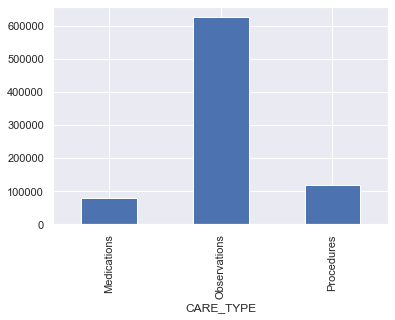

In [82]:
df2 = df_patient_careplans.groupby(['CARE_TYPE'])['CAREPLAN_ID'].count()
print(df2)
df2.plot.bar()

Als nächste wird die Liste der Krankheitszustände extrahiert. Diese wird für die Darstellung der Diagramme benötigt.

In [83]:
# Krankheitszustände
conditions = pd.unique(df_conditions_new["DESCRIPTION"])
print(conditions)

['Coronary Heart Disease' 'Atrial Fibrillation' 'Cardiac Arrest'
 'History of cardiac arrest (situation)' 'Stroke' 'Myocardial Infarction'
 'History of myocardial infarction (situation)'
 'Malignant neoplasm of breast (disorder)']


DESCRIPTION
Atrial Fibrillation                             112300
Cardiac Arrest                                  142900
Coronary Heart Disease                          152700
History of cardiac arrest (situation)           142900
History of myocardial infarction (situation)     26400
Malignant neoplasm of breast (disorder)          94100
Myocardial Infarction                            26400
Stroke                                          129300
Name: CAREPLAN_ID, dtype: int64


<AxesSubplot:ylabel='DESCRIPTION'>

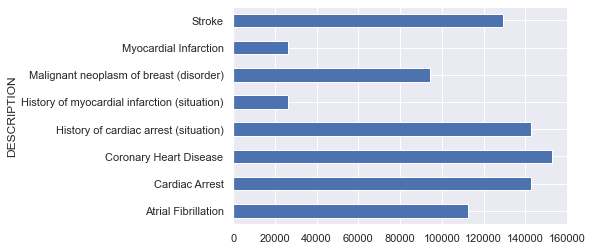

In [84]:
# Anzahl der Patienten mit verschidenen Krabkheiten
df_pat_condition = df_patient_careplans.merge(df_conditions_new, left_on='CONDITIONS_ID', right_on='CONDITIONS_ID')
df4 = df_pat_condition.groupby(['DESCRIPTION'])['CAREPLAN_ID'].count()
print(df4)
df4.plot.barh()

Die Tabelle df_procedures_new wird mit den Tabellen df_procedures_new, df_observations_new und df_medications_new um die Namen den Attributen zu erhalten und die bessere Verständnis zu ermöglichen.

In [85]:
df_care_procedures = df_pat_condition.query("CARE_TYPE == 'Procedures'").merge(df_procedures_new,left_on='TABLE_ID', right_on='PROCEDURES_ID')
df_care_observations = df_pat_condition.query("CARE_TYPE == 'Observations'").merge(df_observations_new,left_on='TABLE_ID', right_on='OBSERVATIONS_ID')
df_care_medicatios = df_pat_condition.query("CARE_TYPE == 'Medications'").merge(df_medications_new,left_on='TABLE_ID', right_on='MEDICATIONS_ID')

Für den Vergleich den Medikamenten, Prozeduren uns Beobachtungen zwischen verschiedenen Krankheitszuständen werden folgende Grafiken erstellt. An Hand diese kann man sehen, dass die Medikamente, Prozeduren und Beobachtungen verschieden und vom Krankheitszustand abhängig sind.

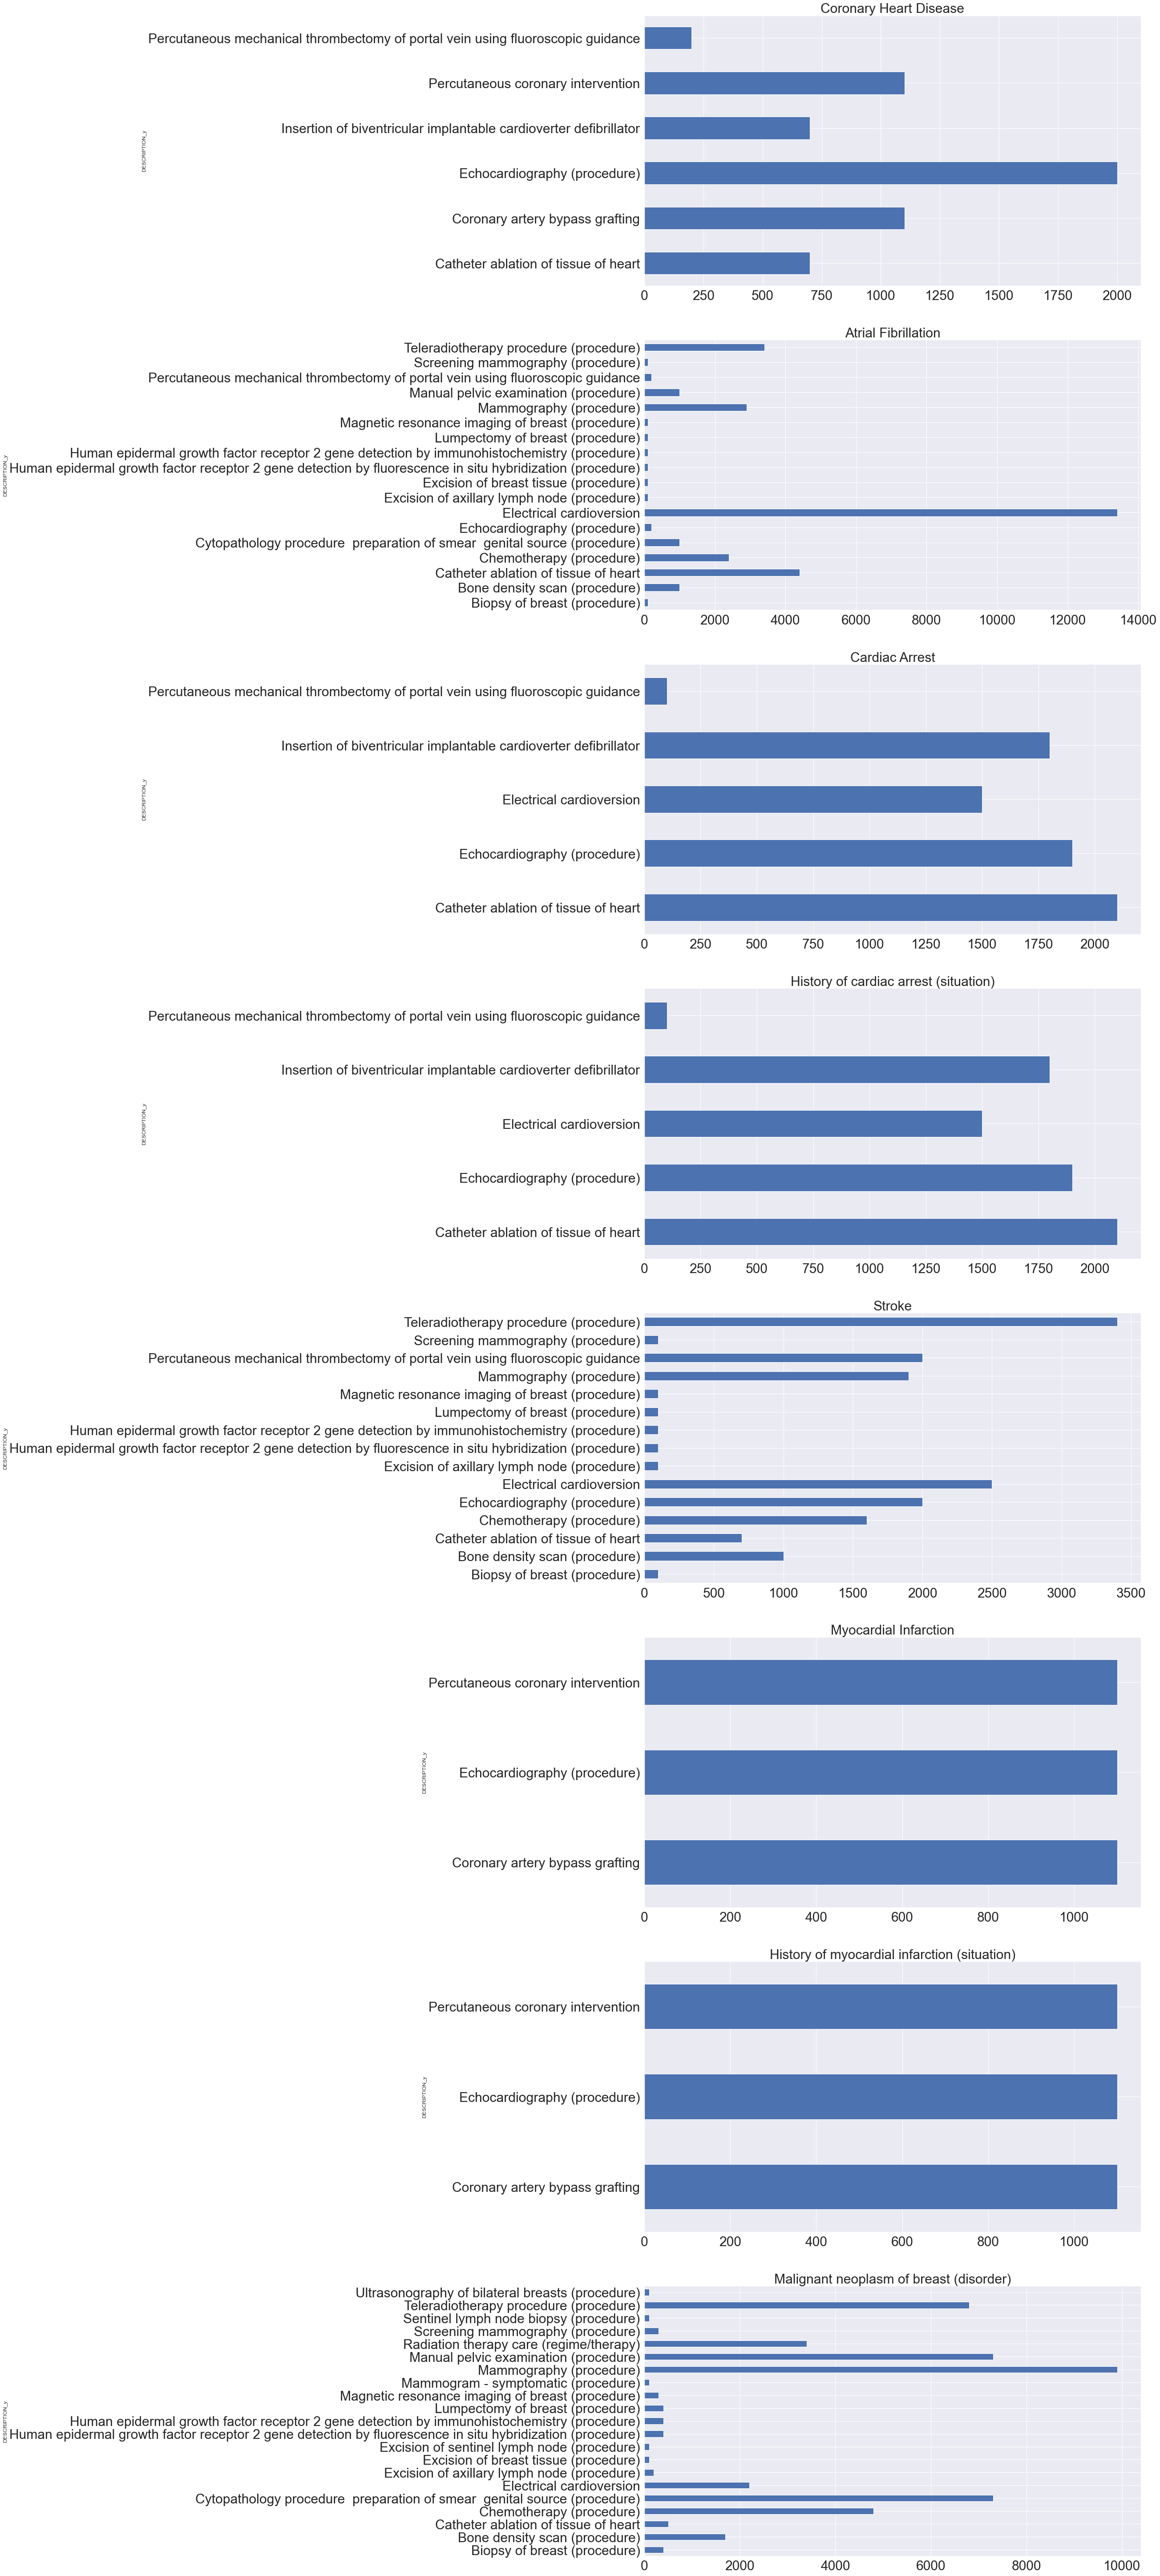

In [86]:
# Prozeduren bei der verschiedenen Krankheiten
fig, axes = plt.subplots(nrows=len(conditions), ncols=1, figsize=(20,105))
for name, ax in zip(conditions, axes):
  df = df_care_procedures[df_care_procedures["DESCRIPTION_x"] == name].groupby(['DESCRIPTION_y'])['CAREPLAN_ID'].count()
  ax.set_title(name,fontsize=30)
  df.plot(ax=ax, kind='barh',fontsize=30)

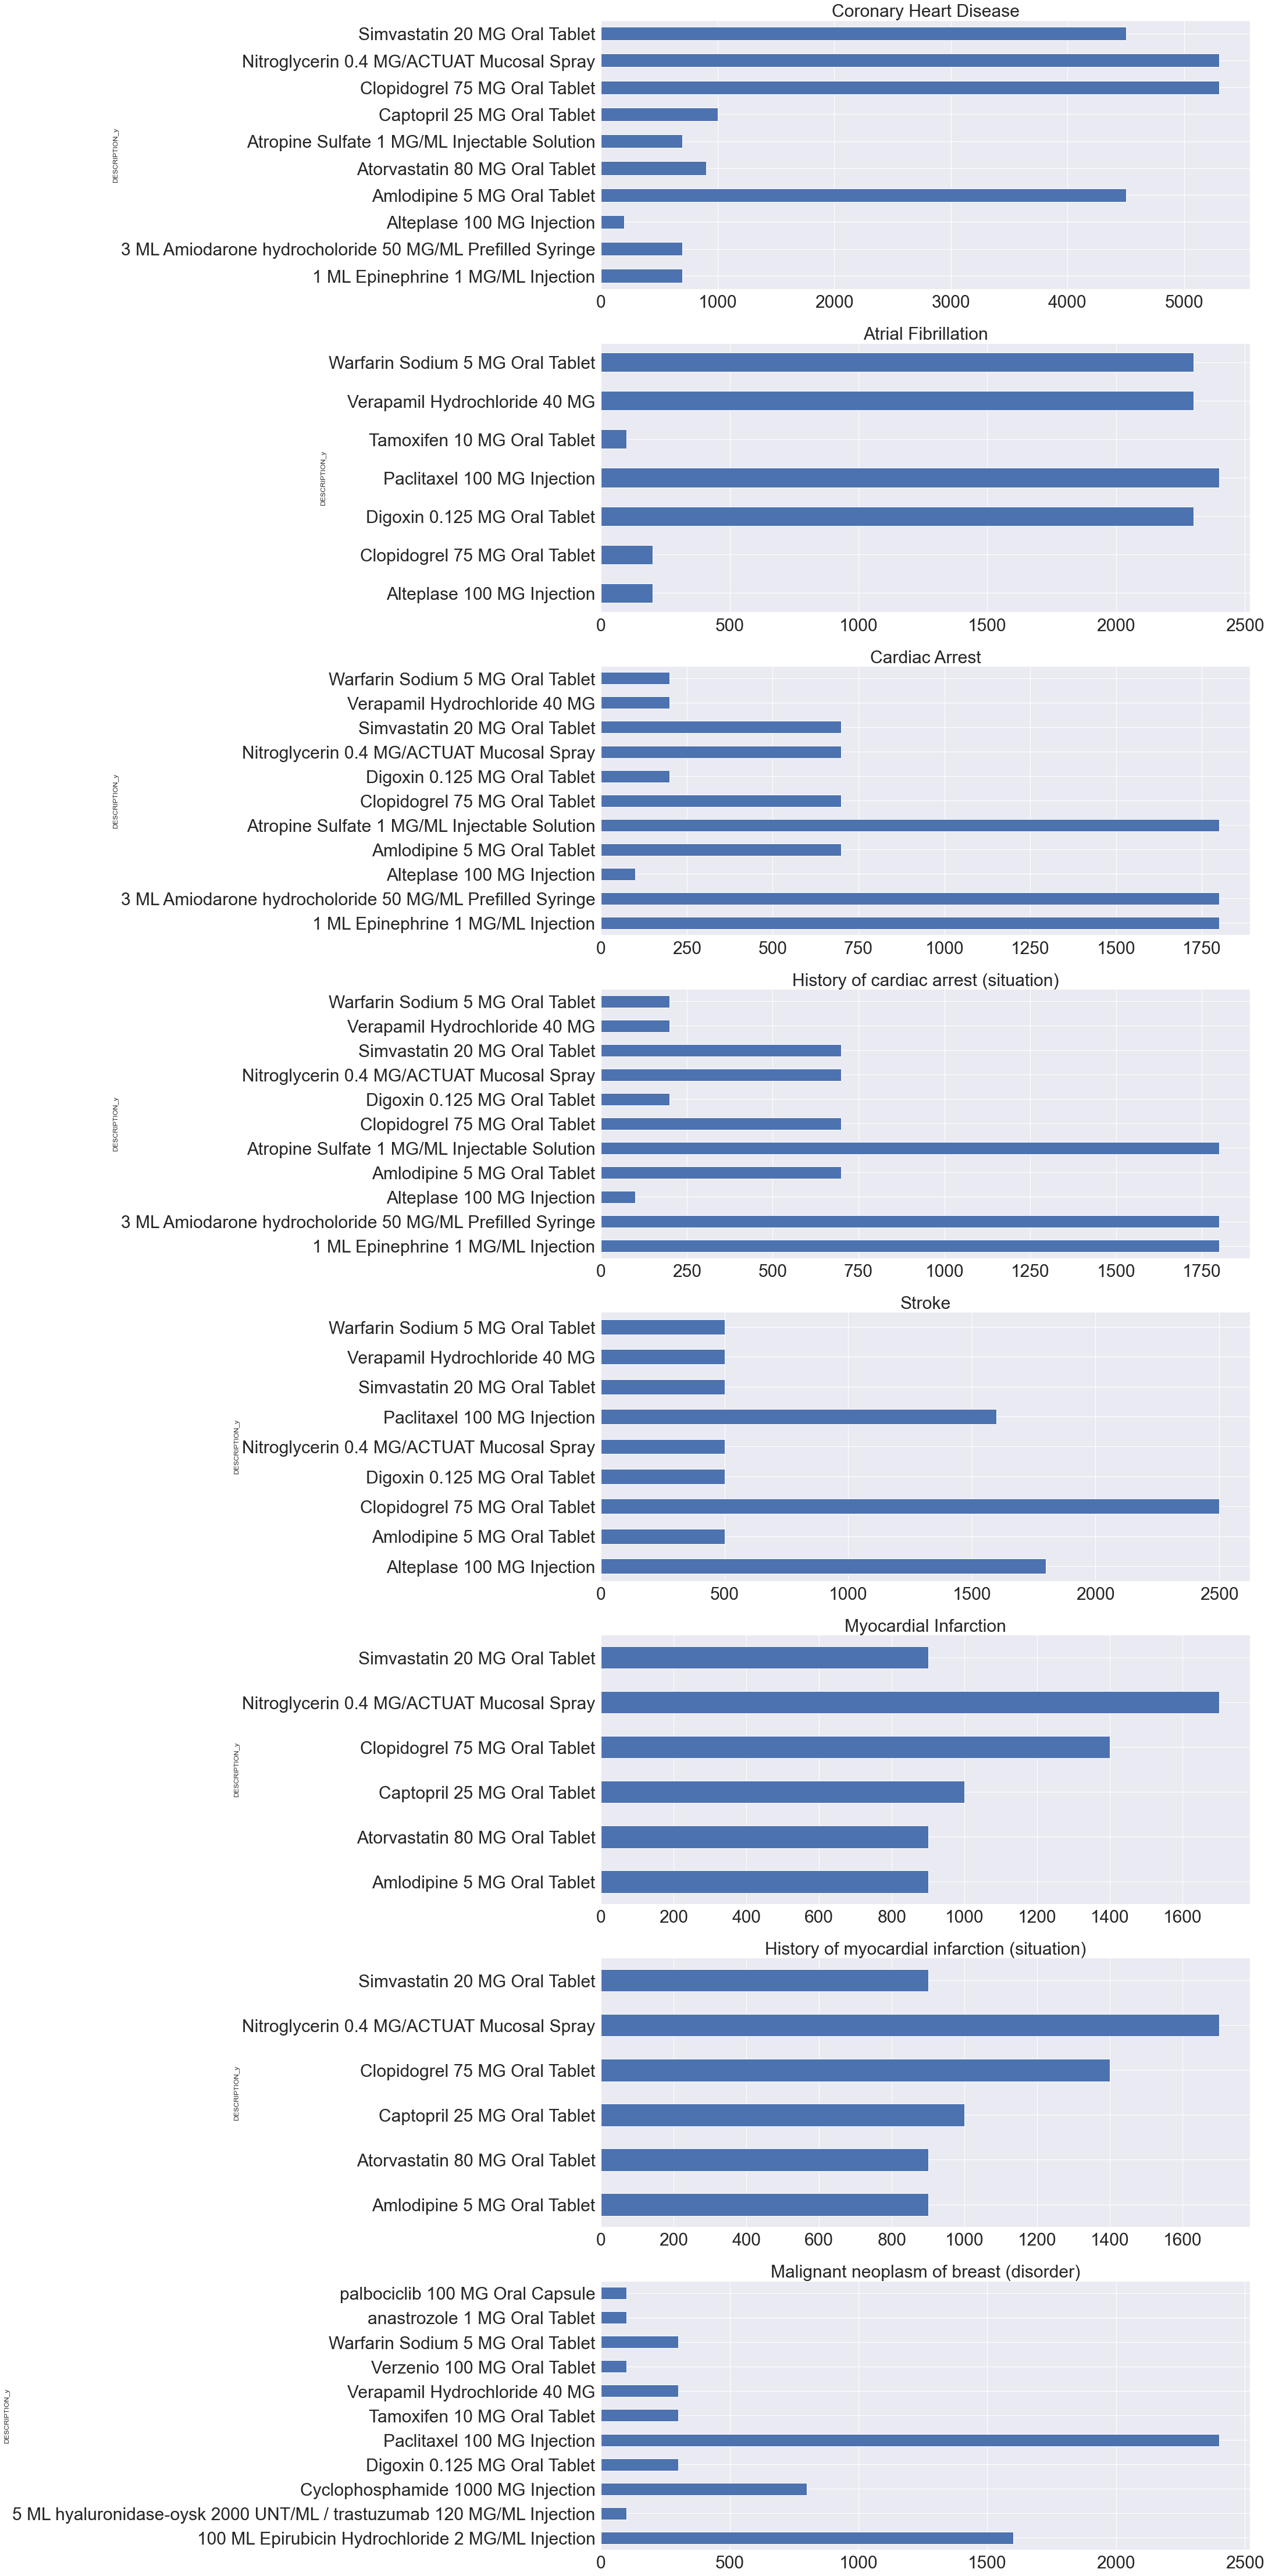

In [87]:
# Medikamenten bei der verschiedenen Krankheiten
fig, axes = plt.subplots(nrows=len(conditions), ncols=1, figsize=(20,80))
for name, ax in zip(conditions, axes):
  df = df_care_medicatios[df_care_medicatios["DESCRIPTION_x"] == name].groupby(['DESCRIPTION_y'])['CAREPLAN_ID'].count()
  ax.set_title(name,fontsize=30)
  df.plot(ax=ax, kind='barh',fontsize=30)

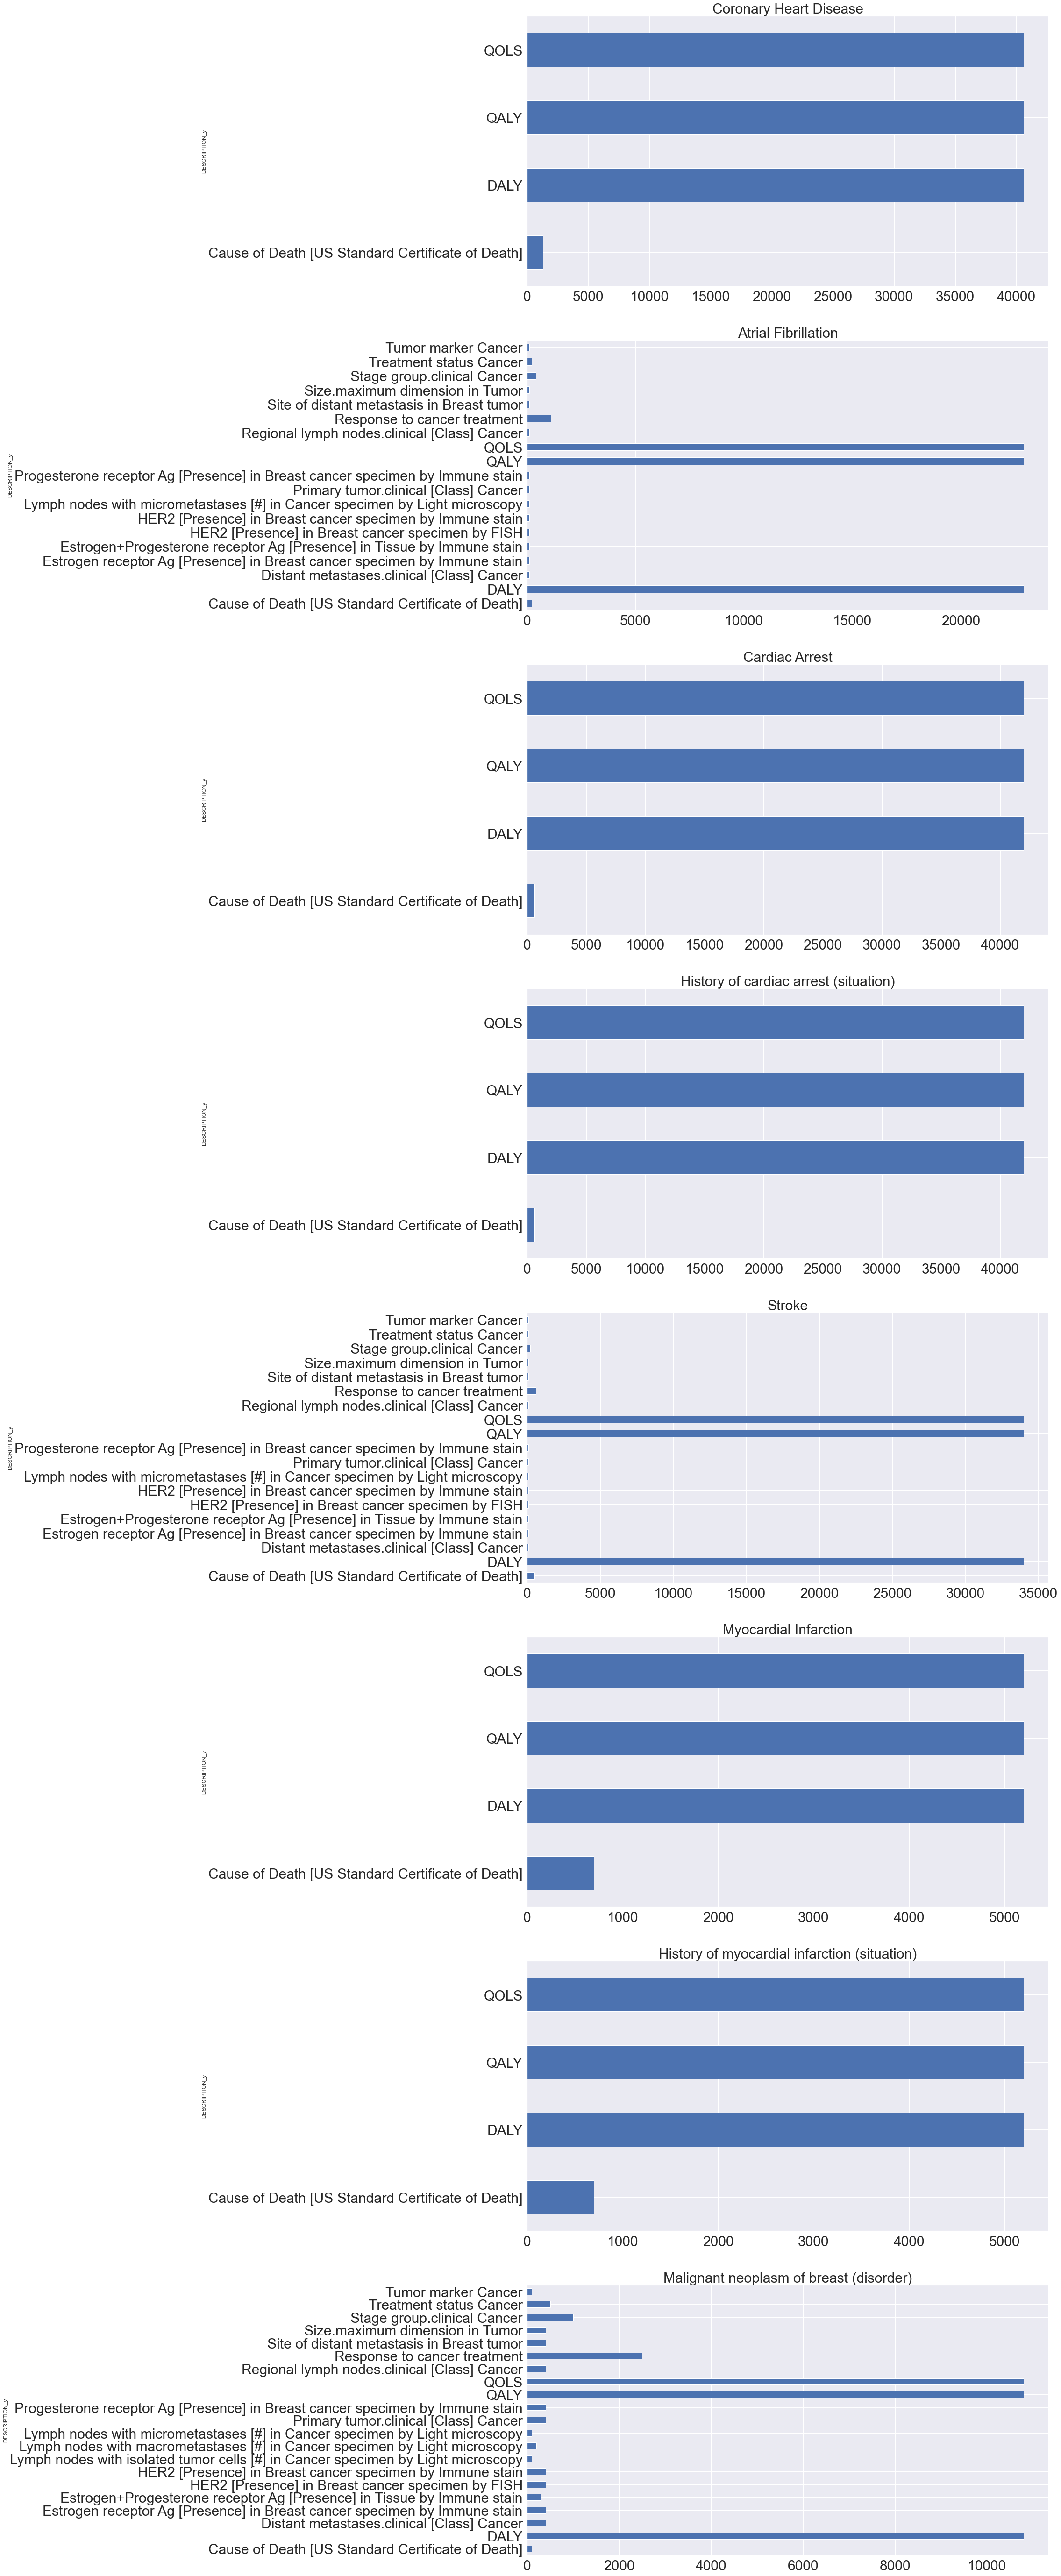

In [88]:
# Beobachtungen bei der verschiedenen Krankheiten
fig, axes = plt.subplots(nrows=len(conditions), ncols=1, figsize=(20,100))
for name, ax in zip(conditions, axes):
  df = df_care_observations[df_care_observations["DESCRIPTION_x"] == name].groupby(['DESCRIPTION_y'])['CAREPLAN_ID'].count()
  ax.set_title(name,fontsize=30)
  df.plot(ax=ax, kind='barh',fontsize=30)

Da wir ein Pharmaunternehmen sind, haben wir die Interessen die Medikationen der Patienten analysieren zu können. Wir haben die Patienten mit der Erkrankung Malignant neoplasm of breast ausgewählt und werden auf die Ähnlichkeit der Behandlung mit Medikamenten analysieren. Zu diesem Zweck haben wir die Patienten nach verschiedenen Annahmen über die Medikamenteneinnahme gruppiert. 

<AxesSubplot:ylabel='DESCRIPTION_y'>

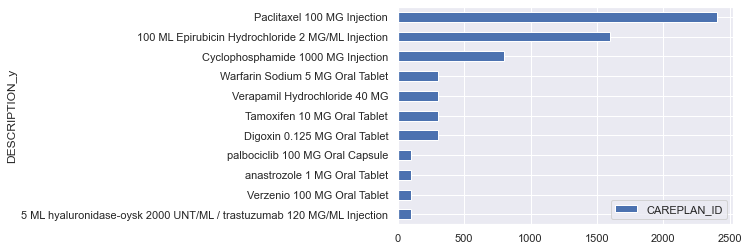

In [89]:
df = df_care_medicatios.query("DESCRIPTION_x == 'Malignant neoplasm of breast (disorder)'").groupby(['DESCRIPTION_y']).agg({"CAREPLAN_ID":"count"})
df_sort = df.sort_values(by=['CAREPLAN_ID'])
df_sort.plot.barh()

Wir wollen im Datenzstz verschidenen Gruppen mit Patienten finden, die auf gleiche/änliche Behandlungen mit Medikamenten haben. Hierfür haben wir die Methode zur Berechnung der Kosten angewendet. Die Kosten werden für eine Reihe von K-Werten dar. In diesem Fall k ist die Anzahl von der Gruppen, was auch Clustern genannt wird. Die Kosten sind die Summe aller Unterschiede zwischen den Clustern. 

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 925.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 925.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 925.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 925.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 925.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16, cost: 819.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 880.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, i

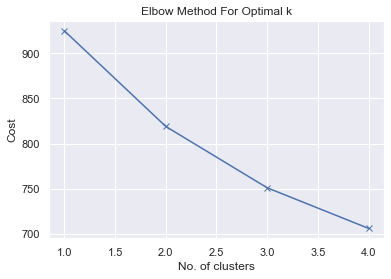

In [90]:
# Zuerst werden die Attribute in Dummy-Variablem umgewandelt
df_patient_count = df_care_medicatios.groupby(['PATIENT_ID','DESCRIPTION_y'])["MEDICATIONS_ID"].count().reset_index()
df_cl_dummies = pd.get_dummies(df_patient_count)

# Elbow curve to find optimal K
cost = []
K = range(1,5)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(df_cl_dummies)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


Die obere Abbildung zeigt, dass die optimale Anzahl der Cluster 3 ist.
Als Nächstes wenden wir kmeans-Algorithmus auf unseren Datensatz auf.

In [91]:
# n_clusters ist die Anzahl der Cluster, bei uns ist 3
kmeans = KMeans(n_clusters=3).fit(df_cl_dummies)
df_patient_count.loc[:,"cluster"] = kmeans.labels_
df_patient_count.head()

PATIENT_ID  \
0  02db7f22-8617-0cf7-fa10-d820d596a81a   
1  02db7f22-8617-0cf7-fa10-d820d596a81a   
2  02db7f22-8617-0cf7-fa10-d820d596a81a   
3  02db7f22-8617-0cf7-fa10-d820d596a81a   
4  037404e1-0c87-534d-0fe2-e21ef20640f6   

                               DESCRIPTION_y  MEDICATIONS_ID  cluster  
0                Amlodipine 5 MG Oral Tablet             100        0  
1              Clopidogrel 75 MG Oral Tablet             100        0  
2  Nitroglycerin 0.4 MG/ACTUAT Mucosal Spray             100        0  
3              Simvastatin 20 MG Oral Tablet             100        0  
4         1 ML Epinephrine 1 MG/ML Injection             300        0

Die folgende Grafik stellt die Anzahl den Medikamenten in den verschiedenen Cluster da. Man kann erkennen den Unterschied durch die Anzahl der Medikamente. Ein Cluster enthält nur ein Patient, was man auch als Ausreißer betrachten kann. Daraus folgt, dass wir die Patienten in zwei Gruppen aufteilen können und jede Gruppe getrennt näher analysieren können.  

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


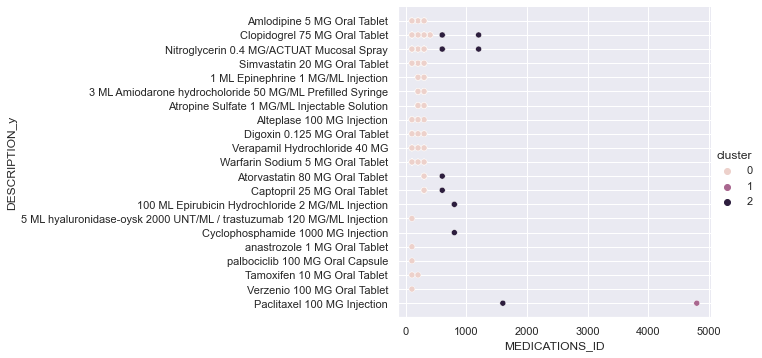

In [92]:
sns.relplot(
    data=df_patient_count, x="MEDICATIONS_ID" , y="DESCRIPTION_y",  hue = "cluster")

Auf der folgenden Grafik ist es besser zu sehen, dass nur ein Patient einem Cluster zugewiesen wurde.

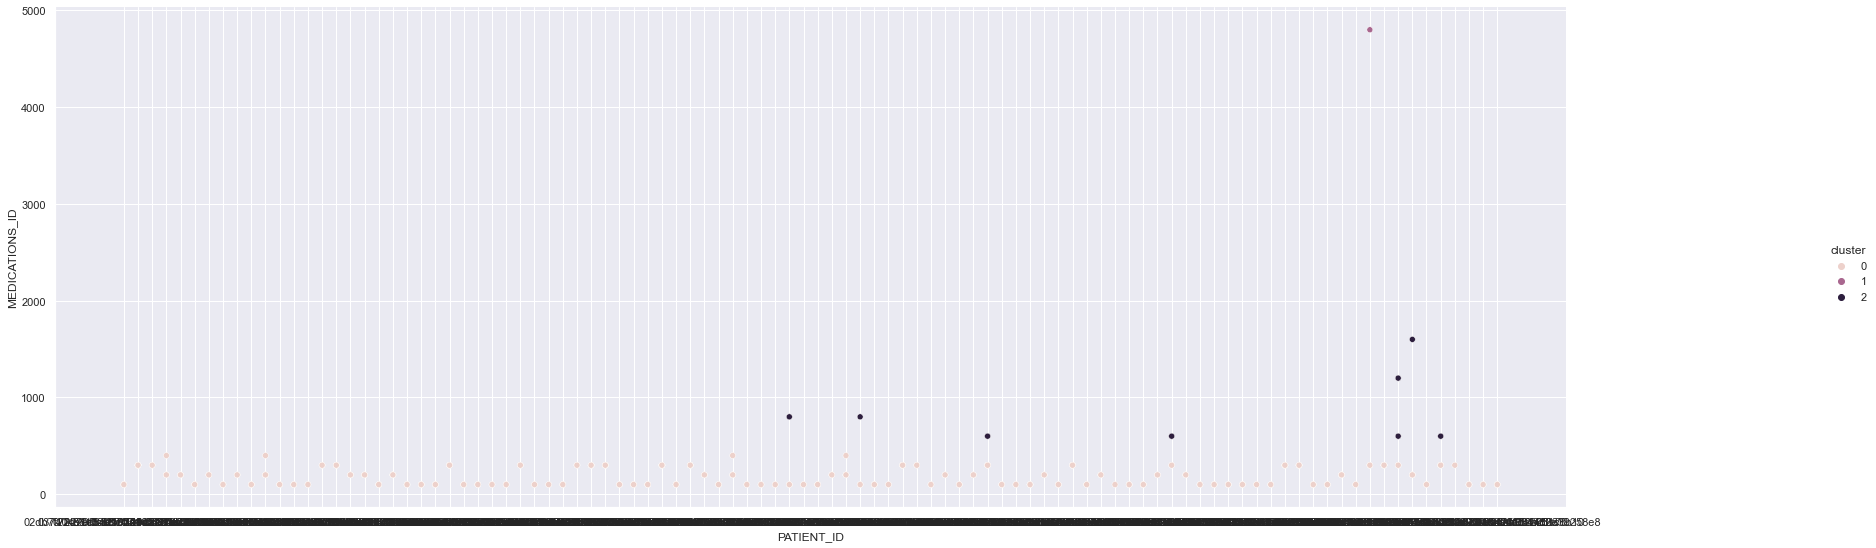

In [93]:
df_med_count = df_patient_count.groupby(['PATIENT_ID','cluster']).agg({"MEDICATIONS_ID":"count"})
sns.relplot(data=df_patient_count, x="PATIENT_ID",y="MEDICATIONS_ID" , hue = "cluster")
plt.gcf().set_size_inches(35, 8)

Anzahl der Patienten in jedem Cluster:

In [94]:
df_patient_count.groupby(['cluster'])['PATIENT_ID'].count()

cluster
0    351
1      1
2     14
Name: PATIENT_ID, dtype: int64

In [95]:
conn.close()